# Train without normalize

This notebook will use the KuHar view (balanced_motionsense_equivalent_view) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import KuHar_BalancedView20HzMotionSenseEquivalent
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-31 13:14:04.304946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 13:14:04.304967: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load KuHar, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = KuHar_BalancedView20HzMotionSenseEquivalent("../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
                              download=False)
train_val, test = loader.load(concat_train_validation=True, label="standard activity code")
train_val

PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code'

In [4]:
train_val.window_names, train_val.window_slices

(['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)])

In [5]:
# Checking the whole data...
train_val[:][0]

array([[ -1.04282825,   7.06961015,   3.45567162, ...,   0.50890319,
         -0.11305444,  -0.38018973],
       [ -2.43790048,  -2.62844861,  -2.16686063, ...,  -0.09413675,
         -0.23829967,   0.3772596 ],
       [ -0.66433712,   0.48346468,   3.09023849, ...,   0.28845053,
          0.11892508,   0.28859494],
       ...,
       [  3.92724394,  19.31137994,   0.4036726 , ...,   0.92610044,
          1.03635366,  -0.09064377],
       [ -7.20889409, -11.73424672,  13.67743163, ...,  -0.13913523,
          0.74242743,   0.76542017],
       [ -1.30519969,   0.77625489,  -2.01040912, ...,   0.53948006,
          1.16119165,  -0.4627136 ]])

In [6]:
train_val[0][0].shape

(360,)

In [7]:
# Create the objects

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [8]:
# Transform it and generate a new dataset!
train_val_fft = transformer(train_val)
test_fft = transformer(test)

In [9]:
# Checking the whole data...
train_val_fft[:][0]

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  0.61856338,
         1.44669533,  0.76661466],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  0.33707892,
         0.57328104,  1.73237447],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.28323215,
         0.74769824,  1.31400771],
       ...,
       [37.2112309 , 19.57891073, 22.52651437, ...,  1.15467725,
         1.07398967,  3.41019869],
       [58.00138092, 13.80286188, 11.50619146, ...,  1.93344645,
         6.26234023,  2.55844602],
       [22.52434513, 15.52963032,  4.92321122, ...,  5.31483603,
         3.63845394,  1.15570768]])

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [10]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest

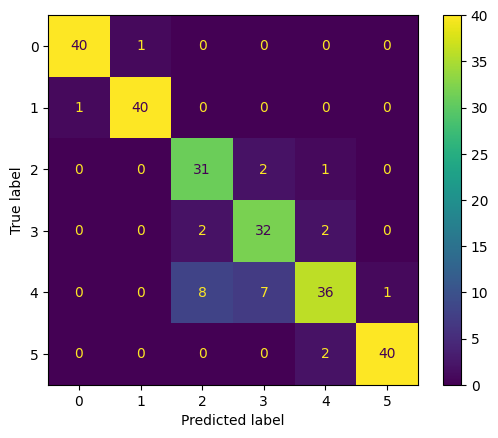

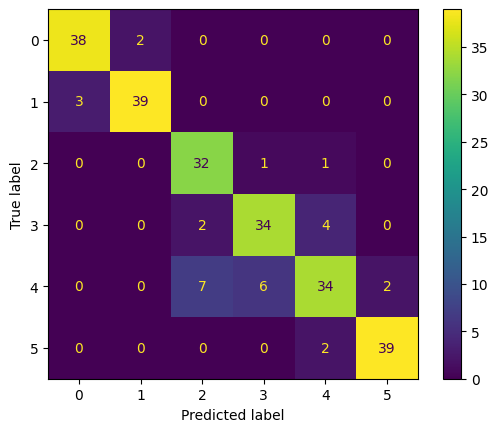

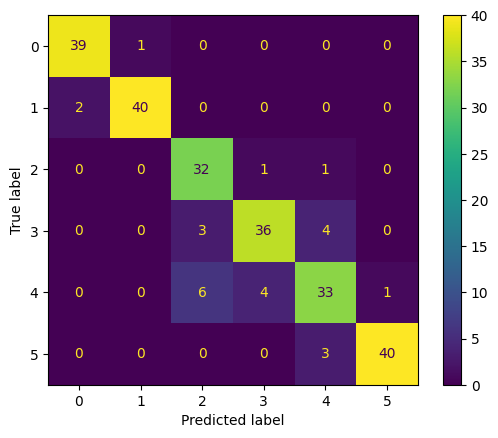

Mean accuracy (3 runs): 0.8875. Mean f1-score: 0.8867


In [46]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### SVM

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


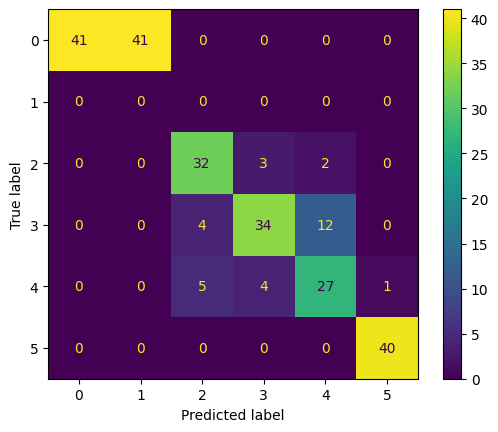

Mean accuracy (3 runs): 0.7073. Mean f1-score: 0.7622


In [12]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

### KNN

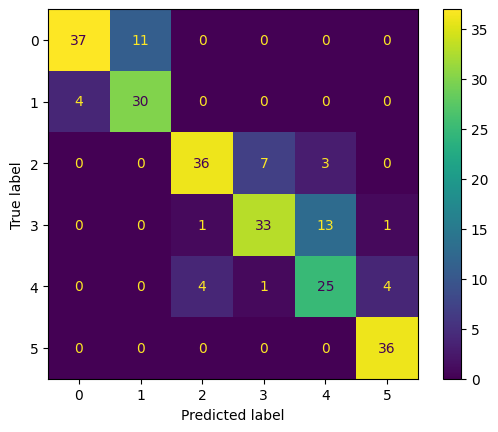

Mean accuracy (3 runs): 0.8008. Mean f1-score: 0.8012


In [13]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_val_fft, [test_fft])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")

## Plot UMAP and T-SNE

In [14]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [15]:
labels = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run"
}
print(labels)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run'}


### UMAP

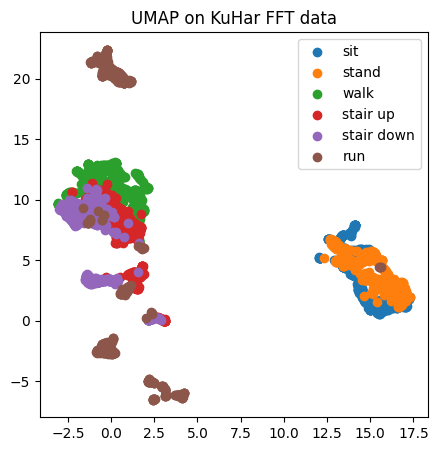

In [20]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
result["label"] = train_val_fft[:][1]
plot(result, title="UMAP on KuHar FFT data", labels = labels)

### T-SNE

In [21]:
# model = TSNE(n_components=2)
# result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
# result["label"] = train_val_fft[:][1]
# plot(result, title="T-SNE on KuHar FFT data", labels = labels)

In [22]:
sample = train_val_fft[:1][0]
sample.shape

(1, 180)

In [24]:
sample_transform = model.transform(sample)
sample_transform

array([[-2.1486626,  9.781781 ]], dtype=float32)

In [29]:
sample_inverse = model.inverse_transform(sample_transform)
sample_inverse

array([[  6.5365663,   3.235186 ,  12.918631 ,  10.191793 ,  19.080223 ,
         30.720913 , 103.767456 ,  52.946625 ,  23.10314  ,  23.054914 ,
         18.99727  ,  21.394445 ,  34.296333 ,  37.809803 ,  21.845577 ,
         21.255165 ,  20.07478  ,  17.525175 ,  25.294632 ,  34.88874  ,
         20.089514 ,  14.831229 ,  12.1485405,  17.336964 ,  14.950163 ,
         16.813425 ,  18.105001 ,  11.711032 ,   7.103064 ,  13.4127   ,
         12.755145 ,   2.3637006,   5.5798597,  29.856386 ,   8.048375 ,
          8.726124 ,  16.381176 ,  12.171529 ,  12.844826 ,  20.624744 ,
         16.702898 ,  13.248168 ,  11.187512 ,  13.98091  ,  17.24368  ,
         23.095278 ,  27.566479 ,  19.952778 ,  16.560009 ,  12.914337 ,
         12.124414 ,  17.652998 ,  17.271383 ,  14.638542 ,  10.183772 ,
         11.386391 ,  10.715787 ,   4.0192227,  13.191028 ,  11.893935 ,
         12.55001  ,   4.8786874,   5.7969522,  11.643988 ,  10.889936 ,
         17.71943  ,  47.995277 ,  24.884102 ,   9.

In [38]:
diff = sample - sample_inverse
max(np.abs(diff)[0])

85.48057786245076

In [58]:
rf = multi_run_experiment.workflow.

In [59]:
rf.predict(sample)

AttributeError: 'bool' object has no attribute 'predict'